# Exercises 1 Answers

## Exercise 1.1

In [142]:
# From https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def fit_exponential(x):
    y = np.exp(x)

    a = np.random.randn()
    b = np.random.randn()
    c = np.random.randn()
    d = np.random.randn()

    learning_rate = 1e-6
    for t in range(8000):
        y_pred = a + b * x + c * x ** 2 + d * x ** 3
        loss = np.square(y_pred - y).sum()
        if t % 200 == 199:
            print(t, loss)
        # Backprop to compute gradients of a, b, c, d with respect to loss
        grad_y_pred = 2.0 * (y_pred - y)
        grad_a = grad_y_pred.sum()
        grad_b = (grad_y_pred * x).sum()
        grad_c = (grad_y_pred * x ** 2).sum()
        grad_d = (grad_y_pred * x ** 3).sum()
        # Update weights
        a -= learning_rate * grad_a
        b -= learning_rate * grad_b
        c -= learning_rate * grad_c
        d -= learning_rate * grad_d
    return (a, b, c, d)

199 678.1588351009298
399 578.5649875647107
599 534.9437836779666
799 515.833472422182
999 507.45899654658785
1199 503.78799924315456
1399 502.17822083363654
1599 501.4720247371195
1799 501.1620786812457
1999 501.02597306174255
2199 500.9661696192835
2399 500.93987472730674
2599 500.92830426274537
2799 500.9232085126534
2999 500.9209620869528
3199 500.9199706693363
3399 500.91953258119327
3599 500.91933872833283
3799 500.919252815036
3999 500.91921467301336
4199 500.9191977067617
4399 500.91919014372303
4599 500.9191867644018
4799 500.9191852505473
4999 500.91918457046347
5199 500.9191842640074
5399 500.91918412545795
5599 500.9191840625978
5799 500.9191840339707
5999 500.91918402088214
6199 500.91918401487294
6399 500.9191840121018
6599 500.9191840108186
6799 500.91918401022144
6999 500.9191840099424
7199 500.9191840098114
7399 500.9191840097495
7599 500.91918400972025
7799 500.9191840097063
7999 500.9191840096997
Result: y = 0.5000522005217442 + 0.7393320506520884 x + 0.9656339145977

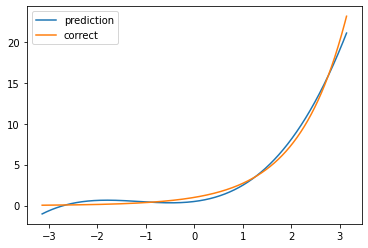

In [165]:
# Run this to test your code

def show_result():
    print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')
    x_data = np.linspace(-math.pi, math.pi, 2000)
    y_data = a + b*x_data + c*np.power(x_data,2) + d*np.power(x_data,3)
    fig, ax = plt.subplots()
    ax.plot(x_data, y_data, label='prediction')
    ax.plot(x_data, np.exp(x_data), label='correct')
    ax.legend()
    plt.show()
    
a, b, c, d = fit_exponential(np.linspace(-math.pi, math.pi, 2000))
show_result()
np.testing.assert_allclose((a,b,c,d), (0.500051380635291, 0.7393321213180061, 0.9656340560418195, 0.28151141256621487), rtol=1e-1)

## Exercise 1.2

In [91]:
# From https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
import torch
import math


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'

In [169]:
def polynomial_fit_pytorch(x):
    y = torch.exp(x)

    model = Polynomial3()

    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the nn.Linear
    # module which is members of the model.
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

    for t in range(8000):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)

        # Compute and print loss
        loss = criterion(y_pred, y)
        if t % 400 == 399:
            print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

399 1181.0106201171875
799 671.3935546875
1199 543.655517578125
1599 511.6336975097656
1999 503.605712890625
2399 501.5928955078125
2799 501.0882568359375
3199 500.961669921875
3599 500.929931640625
3999 500.9219665527344
4399 500.91998291015625
4799 500.9195556640625
5199 500.91943359375
5599 500.91937255859375
5999 500.9193115234375
6399 500.91937255859375
6799 500.9193115234375
7199 500.9193115234375
7599 500.9193115234375
7999 500.9193115234375
Result: y = 0.5000522005217442 + 0.7393320506520884 x + 0.9656339145977635 x^2 + 0.2815114226178263 x^3


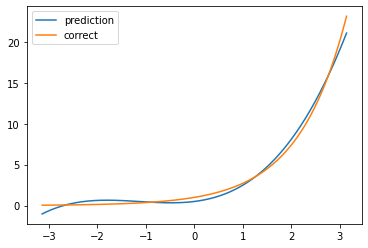

In [170]:
# Run this to test your code

def show_result():
    print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')
    x_data = np.linspace(-math.pi, math.pi, 2000)
    y_data = model.a.item() + model.b.item()*x_data + model.c.item()*np.power(x_data,2) + model.d.item()*np.power(x_data,3)
    fig, ax = plt.subplots()
    ax.plot(x_data, y_data, label='prediction')
    ax.plot(x_data, np.exp(x_data), label='correct')
    ax.legend()
    plt.show()
    
model = polynomial_fit_pytorch(torch.linspace(-math.pi, math.pi, 2000))
show_result()
np.testing.assert_allclose((model.a.item(),model.b.item(),model.c.item(),model.d.item()), (0.500051380635291, 0.7393321213180061, 0.9656340560418195, 0.28151141256621487), rtol=1e-1)

## Exercise 1.3

In [167]:
def polynomial_fit_pytorch_rmsprop(x):
    y = torch.exp(x)

    model = Polynomial3()

    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the nn.Linear
    # module which is members of the model.
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2)


    for t in range(8000):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)

        # Compute and print loss
        loss = criterion(y_pred, y)
        if t % 400 == 399:
            print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

399 1651.6136474609375
799 510.60003662109375
1199 501.8135681152344
1599 514.8855590820312
1999 511.7413330078125
2399 511.3420715332031
2799 511.287353515625
3199 511.2799987792969
3599 511.2793884277344
3999 511.2793884277344
4399 511.279296875
4799 511.27899169921875
5199 511.2784423828125
5599 511.27880859375
5999 511.2784118652344
6399 511.2786560058594
6799 511.2788391113281
7199 511.27850341796875
7599 511.27899169921875
7999 511.2790222167969
Result: y = 0.5000522005217442 + 0.7393320506520884 x + 0.9656339145977635 x^2 + 0.2815114226178263 x^3


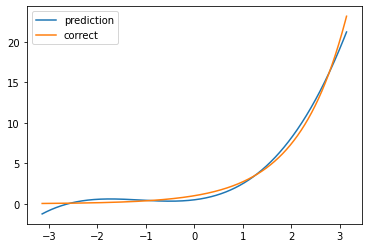

In [168]:
# Run this to test your code

def show_result():
    print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')
    x_data = np.linspace(-math.pi, math.pi, 2000)
    y_data = model.a.item() + model.b.item()*x_data + model.c.item()*np.power(x_data,2) + model.d.item()*np.power(x_data,3)
    fig, ax = plt.subplots()
    ax.plot(x_data, y_data, label='prediction')
    ax.plot(x_data, np.exp(x_data), label='correct')
    ax.legend()
    plt.show()
    
model = polynomial_fit_pytorch_rmsprop(torch.linspace(-math.pi, math.pi, 2000))
show_result()
np.testing.assert_allclose((model.a.item(),model.b.item(),model.c.item(),model.d.item()), (0.500051380635291, 0.7393321213180061, 0.9656340560418195, 0.28151141256621487), rtol=1e-1)